In [117]:
from extract import SocialETL, construct_query_for_twarc, extract_tags, SocialDB, UserETL
import hashtags as h
import hashtags_readcsv as r_csv
import pandas as pd
import numpy as np
import json
import statistics
import networkx as nx
from numpy import nan

# 1) Download DF

In [118]:
#modifiche: cambiare data e togliere lang eng
m = SocialETL(query="(#strangerthings4 OR #onepiece OR #covid OR #pridemonth OR #grammys OR #justiceforjohnnydepp OR #putin OR #russia OR #ukraine OR #war)", pages=10, recent=False) #strangerthings4 

Output()

In [119]:
m.df.head(3)

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,retweeted_user_id,quoted_user_id,created_at,...,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type,__twarc.retrieved_at,__twarc.url,__twarc.version,
0,1559482874637828097,1559482874637828097,NaN,1559456848322904064,NaN,1357334523877281794,NaN,1891490382,NaN,2022-08-16T10:11:05.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-16T10:11:20+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.11.0,NaN
1,1559482871341109249,1559423383166648320,1559423383166648320,NaN,NaN,1526535712090243073,1526535712090243073,NaN,NaN,2022-08-16T10:11:04.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-16T10:11:20+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.11.0,NaN
2,1559482870976102400,1559482870976102400,NaN,NaN,NaN,3306847863,NaN,NaN,NaN,2022-08-16T10:11:04.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-16T10:11:20+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.11.0,NaN


In [120]:
m.df=m.df.dropna(subset=['entities.hashtags'])
m.df=m.df.dropna(subset=['retweeted_user_id'])

In [121]:
m.df['entities.hashtags']=m.df['entities.hashtags'].apply(eval)
m.df['entities.hashtags']=m.df['entities.hashtags'].map(h.extract_tags)
#m.df['retweeted_user_id']=m.df['retweeted_user_id'].tolist()
#m.df['conversation_id']=m.df['conversation_id'].tolist()
#m.df['author.location']=m.df['author.location'].tolist()
#m.df['author.verified']=m.df['author.verified'].tolist()
#m.df['id']=m.df['id'].tolist()

In [122]:
#create a pandas dataframe
df_nodes=pd.DataFrame({"user_id":m.df['author_id'],
                       'tweet_id':m.df['id'],
                      'retweet_id': m.df['retweeted_user_id'],
                       'conversation_id':m.df['conversation_id'],
                      "hashtag":m.df['entities.hashtags'],
                     'location':m.df['author.location'],
                     'verified':m.df['author.verified']})

In [123]:
df_nodes.set_index('user_id',inplace=True)

In [124]:
df_nodes['hashtag']=df_nodes['hashtag'].map(str).apply(eval)
df_nodes['tweet_id']=df_nodes['tweet_id'].map(str).apply(eval)
df_nodes['conversation_id']=df_nodes['conversation_id'].map(str).apply(eval)
df_nodes['retweet_id']=df_nodes['retweet_id'].map(str).apply(eval)
df_nodes['location']=df_nodes['location'].map(str)#.apply(eval)
df_nodes['verified']=df_nodes['verified'].map(str).apply(eval)

In [125]:
df_nodes.head(3)

,tweet_id,retweet_id,conversation_id,hashtag,location,verified
user_id,,,,,,
1357334523877281794,1559482874637828097,1891490382,1559482874637828097,"[russian, russia, donbas, belarus, kazakhstan]",nan,False
1328197996975071232,1559482868212314114,1363523274,1559482868212314114,"[myanmar, military, russians, russia, whatshap...",nan,False
1669821648,1559482868149227520,49408718,1559482868149227520,[russia],Hamburg,False


## preprocessing 

In [126]:
#convert nested lists on set
def to_sets(nested_lists): 
    outer_list = set()
    for el in nested_lists: 
        if type(el) == list: 
            outer_list.update(el) 
        else: 
            outer_list.add(el)
    return outer_list
df_nodes['hashtag']=df_nodes['hashtag'].map(to_sets)

In [127]:
#df_nodes['hashtag']=df_nodes['hashtag'].map(to_sets)
#df_nodes['tweet_id']=df_nodes['tweet_id'].apply(to_sets2)
#df_nodes['conversation_id']=df_nodes['conversation_id'].map(to_sets2)
#df_nodes['retweet_id']=df_nodes['retweet_id'].str.map(set)
#df_nodes['verified']=df_nodes['verified'].map(to_sets2)
#df_nodes['location']=df_nodes['location'].map(to_sets2)

In [128]:
df_nodes.head(3)

,tweet_id,retweet_id,conversation_id,hashtag,location,verified
user_id,,,,,,
1357334523877281794,1559482874637828097,1891490382,1559482874637828097,"{russian, belarus, donbas, kazakhstan, russia}",nan,False
1328197996975071232,1559482868212314114,1363523274,1559482868212314114,"{military, russians, whatshappeninginmyanmar, ...",nan,False
1669821648,1559482868149227520,49408718,1559482868149227520,{russia},Hamburg,False


In [129]:
df_nodes.shape

(824, 6)

In [130]:
#df_nodes.to_csv('df_nodes')

# 2) Categorizzazione utenti

In [131]:
with open('hashtags_300.json', 'r') as f:
    my_dict = json.load(f)

In [132]:
proukr=set()
prorus=set()
pax=set()
for k,v in my_dict.items():
    for e in v:
        if k=='proukr':
            proukr.update(e)
        elif k=='pax':
            pax.update(e)
        elif k=='prorus':
            prorus.update(e)

In [133]:
cat=set.union(proukr,prorus,pax)
count1=0
count4=0
index1=[]
index4=[]

for i, row in enumerate(df_nodes['hashtag']): 
    if row.intersection(cat)==set():#no intersezione   
        #print(row.intersectionn(cat))
        #print("l'utente {}  appartiene alla 4 categoria".format(row.intersection(cat)))
        #print("4 categoria", row)
        count4 += 1
        index4.append(df_nodes.index[i])
        
    else: #c'è intersezione: uno della 3 categorie
        #print("non è la 4 categoria perchè contiene",row.intersection(cat))
       # if row.intersection(proukr)!=set(): #c'è intersez con proukr
            count1 += 1
            index1.append(i) #aggiungo alle rige da tgliere
            print("l'utente {} non  appartiene alla 4 categoria perchè usa {}".format(df_nodes.index[i],row.intersection(cat)))

l'utente 1357334523877281794 non  appartiene alla 4 categoria perchè usa {'donbas', 'russia', 'russian', 'belarus'}
l'utente 1328197996975071232 non  appartiene alla 4 categoria perchè usa {'russia', 'russians'}
l'utente 1669821648 non  appartiene alla 4 categoria perchè usa {'russia'}
l'utente 972483006 non  appartiene alla 4 categoria perchè usa {'uk', 'nazirussia', 'russia', 'russiaisaterroriststate', 'putinwarcriminal'}
l'utente 1461419096059359241 non  appartiene alla 4 categoria perchè usa {'russia'}
l'utente 1204929172327555073 non  appartiene alla 4 categoria perchè usa {'hitler', 'india', 'japan', 'taiwan', 'russia', 'germany'}
l'utente 1353284600915763200 non  appartiene alla 4 categoria perchè usa {'genocide', 'ukraine'}
l'utente 870396788288741376 non  appartiene alla 4 categoria perchè usa {'standwithukraine', 'russiawarcrimes', 'mariupol', 'ukrainian', 'stoprussia', 'ukraine'}
l'utente 1388547558688051204 non  appartiene alla 4 categoria perchè usa {'putin', 'crimea', 'kr

l'utente 1354347946054197248 non  appartiene alla 4 categoria perchè usa {'russia', 'crimea'}
l'utente 438224887 non  appartiene alla 4 categoria perchè usa {'georgia', 'russia'}
l'utente 1159100068147978243 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 54345317 non  appartiene alla 4 categoria perchè usa {'putin'}
l'utente 1204929172327555073 non  appartiene alla 4 categoria perchè usa {'france', 'nato', 'usa', 'afghanistan', 'peace', 'russia', 'europe', 'ukraine', 'joebiden'}
l'utente 1308470459273486336 non  appartiene alla 4 categoria perchè usa {'donbas', 'russia', 'russian', 'belarus'}
l'utente 1129403103156068352 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 1496926113976791049 non  appartiene alla 4 categoria perchè usa {'army', 'ukraine', 'ukr', 'marioupol'}
l'utente 434694285 non  appartiene alla 4 categoria perchè usa {'taiwan', 'ukraine', 'nowar'}
l'utente 422153063 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 152718

l'utente 1441383776127311877 non  appartiene alla 4 categoria perchè usa {'standwithukraine', 'helpukraine', 'ukraine', 'stoprussianaggression', 'warinukraine', 'nft', 'russiainvadedukraine', 'ukraineunderattak', 'artforukraine', 'nfts', 'stopwar'}
l'utente 1354347946054197248 non  appartiene alla 4 categoria perchè usa {'nato', 'zelensky', 'donbass', 'russia', 'ukraine'}
l'utente 895716860330622978 non  appartiene alla 4 categoria perchè usa {'genocide', 'ukraine'}
l'utente 1504903461158232066 non  appartiene alla 4 categoria perchè usa {'habeck', 'putin'}
l'utente 1543853250197471233 non  appartiene alla 4 categoria perchè usa {'nft'}
l'utente 1488366516009504768 non  appartiene alla 4 categoria perchè usa {'nft'}
l'utente 1499306502058037248 non  appartiene alla 4 categoria perchè usa {'ukraine', 'war'}
l'utente 1360860083211677696 non  appartiene alla 4 categoria perchè usa {'ukraine', 'propaganda'}
l'utente 195746945 non  appartiene alla 4 categoria perchè usa {'btc', 'eth', 'nft'

l'utente 1091346244969078784 non  appartiene alla 4 categoria perchè usa {'ukraine', 'donetsk'}
l'utente 101199519 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 1534116621773549568 non  appartiene alla 4 categoria perchè usa {'nft'}
l'utente 971992127176564736 non  appartiene alla 4 categoria perchè usa {'zelensky', 'ukraine'}
l'utente 2965332038 non  appartiene alla 4 categoria perchè usa {'russia'}
l'utente 1424748656716963847 non  appartiene alla 4 categoria perchè usa {'russia', 'russians'}
l'utente 1070073708600025089 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 421710228 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 1134135270 non  appartiene alla 4 categoria perchè usa {'russia', 'russians'}
l'utente 767912742 non  appartiene alla 4 categoria perchè usa {'zelensky', 'ukraine'}
l'utente 1136142895721930752 non  appartiene alla 4 categoria perchè usa {'russia', 'russians'}
l'utente 424309189 non  appartiene alla 4 categoria

In [134]:
print('nocare = {} \n'
      'altre categorie = {}'.format(count4, count1))

nocare = 517 
altre categorie = 307


In [135]:
df_nodes['cat']="war cat"#pd.NA
for i in index4:
    df_nodes['cat'].loc[i]='nocare'

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# 3 Creazione rete

In [136]:
#df_nodes['location']=df_nodes['location'].map(list)

In [21]:
f={True}
for b in df_nodes['verified']:
    if b.intersection(f)!=set():
        b.discard(False)

In [154]:
G = nx.Graph()
g= list(df_nodes.index)#['user_id'])
G.add_nodes_from(g)# cat=df_nodes['cat'][i], verfied=''.join(str(i) for i in df_nodes['verified'][i])) # ,loc=df_nodes['location'][i], verfied=df_nodes['verified'][i])
list(G.nodes.data())

[('1357334523877281794', {}),
 ('1328197996975071232', {}),
 ('1669821648', {}),
 ('972483006', {}),
 ('1187413646395097089', {}),
 ('1525813668394733570', {}),
 ('509373814', {}),
 ('1461419096059359241', {}),
 ('3452038216', {}),
 ('1204929172327555073', {}),
 ('1353284600915763200', {}),
 ('870396788288741376', {}),
 ('1446217721084096524', {}),
 ('150266690', {}),
 ('1115447615682797568', {}),
 ('1388547558688051204', {}),
 ('1240132184889069569', {}),
 ('118272158', {}),
 ('1053174255926501376', {}),
 ('997012785941893121', {}),
 ('935920643106902016', {}),
 ('946014889952210945', {}),
 ('1542092606892429312', {}),
 ('1325062152974110720', {}),
 ('2613166704', {}),
 ('997227764485771264', {}),
 ('1240605146523918336', {}),
 ('797216807547342848', {}),
 ('1049953391235887105', {}),
 ('2903707442', {}),
 ('1314151231963627520', {}),
 ('1133607564736729089', {}),
 ('860895838742208513', {}),
 ('3049002434', {}),
 ('1434142173860020224', {}),
 ('582584886', {}),
 ('1498777994961293318

In [104]:
#crea edges tra nodi
#tentativo 1
index=[]
for i in df_nodes.index:
    index.append({str(i)})
print(len(index))

80


In [158]:
#link retweet
list_edges=[]
for u, user in enumerate(df_nodes.index):
    #print('u',user, type(u))
    for r,ret in enumerate(df_nodes['retweet_id']):
        w = 0
        #print('ret',ret)
        if user==ret:
            print('ok')
            w +=1
            #print('user {u} compare nei retweet di ',.format(u,df_nodes.index[i])
            list_edges.append({'from':user,
                               'to':df_nodes.index[r],
                               'weight':w})
print(len(list_edges))

0


In [155]:
#link retweet
list_edges=[]
for t,tweet in enumerate(df_nodes['tweet_id']):
    #print('t',t, type(t))
    for c,comment in enumerate(df_nodes['conversation_id']):
        #print('ret',ret)
        if tweet==comment: 
            list_edges.append({'from':str(df_nodes.index[t]),
                               'to':str(df_nodes.index[c])})
print(len(list_edges))

824


In [156]:
#add weights: how many times one tweet's user is twetted by an user
edges=[(x["from"], x["to"]) for x in list_edges]
#print(edges)
G.add_edges_from(edges)

In [152]:
G.remove_edges_from(list(nx.selfloop_edges(G)))
#G.remove_nodes_from(list(nx.isolates(G)))

number of nodes = 731 , number of edges = 731 . number of components = 731


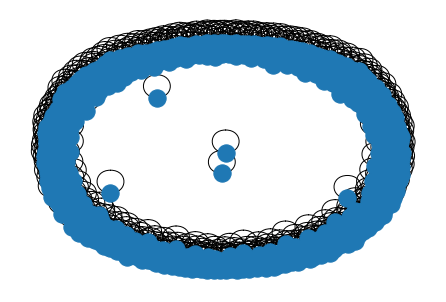

In [157]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
nx.draw(G)
print('number of nodes =',G.number_of_nodes(),', number of edges =', G.number_of_edges(),'. number of components =',c) 

In [41]:
nx.write_gexf(G,'net with 20 conversation.gexf')
#nx.write_gexf(G,'net_50')

In [145]:
for component in list(nx.connected_components(G)):
    c += 1
    if len(component)<10:
        for node in component:
            G.remove_node(node)

number of nodes = 0 , number of edges = 0 . number of components = 0


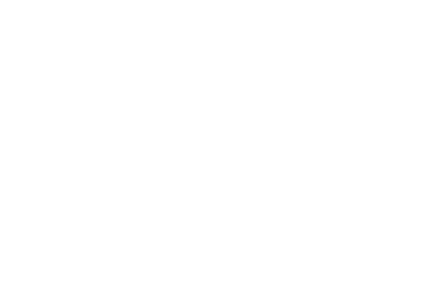

In [146]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
nx.draw(G)
print('number of nodes =',G.number_of_nodes(),', number of edges =', G.number_of_edges(),'. number of components =',c) 

In [43]:
from matplotlib import pylab
def save_graph(graph, file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(40, 40))
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)
    
save_graph(G,'g')
print('number of nodes = ', G.number_of_nodes(),
     'number of edges = ', G.number_of_edges())

NameError: name 'plt' is not defined

In [73]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
print(c)

3


In [78]:
G.number_of_nodes()

719